In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 0 Load Data

In [2]:
############################################################
# LOADING ADMISSIONS AND PATIENTS DF
############################################################
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2019_2020.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

In [3]:
# LOADING EOBS AND OXYGEN SATURATION BEFORE INTERPOLATION =============
data = pickle.load( open('DataFrame_pickles/df_eobs_oxygen_2019_2020_v2.pickle', 'rb'))
df_eobs_old = data[0]
df_oxyge    = data[1]
# LOADING EOBS AFTER INTERPOLATION ====================================
#df_eobs_new = pickle.load( open('DataFrame_pickles/df_eobs_3d_old.pickle', 'rb'))
df_eobs_new = pickle.load( open('DataFrame_pickles/df_eobs_3d.pickle', 'rb'))

# 1. Data Checks

### 1.1. Admissions

In [4]:
print('Admissions in admissions', len(df_admissions))
print('')

print('Admissions in Eobs_old', len(df_eobs_old['admission_id'].unique()))
print('Admissions in Eobs_new', len(df_eobs_new['admission_id'].unique()))

Admissions in admissions 15001

Admissions in Eobs_old 14714
Admissions in Eobs_new 11178


### 1.2 null values

In [5]:
df = pd.concat([df_eobs_old.isna().sum(), df_eobs_old.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df)
display(df_eobs_old.describe())

,nulls,type
admission_id,0,int64
patient_id,0,int64
timestamp,0,datetime64[ns]
time_since_prev_obs_in_mins,0,object
rr,0,int64
ews,0,int64
heart_rate,4989,float64
temperature\r,11253,float64
timestamp_code,0,float64
sbp,9707,float64


,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,890914.000,890914.000,890914.000,890914.000,885925.000,879661.000,890914.000,881207.000,881207.000
mean,49872756.469,49809253.768,19.167,2.519,83.501,36.814,18654.037,124.080,71.110
std,28539211.952,28796620.411,3.470,2.307,16.501,0.633,198.332,20.702,13.169
min,7126.000,943.000,5.000,0.000,20.000,30.000,18293.002,60.000,40.000
25%,25339354.000,24519865.000,18.000,1.000,72.000,36.400,18497.907,110.000,62.000
50%,49516492.000,49890886.000,18.000,2.000,83.000,36.700,18649.843,122.000,70.000
75%,74346285.000,74544224.000,20.000,4.000,93.000,37.100,18827.609,137.000,79.000
max,99995341.000,99996757.000,40.000,20.000,160.000,42.000,19038.550,200.000,120.000


In [6]:
df = pd.concat([df_eobs_new.isna().sum(), df_eobs_new.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df)
df_eobs_new = df_eobs_new.astype({'rr':'float', 'ews':'float', 'heart_rate':'float', 'temperature\r':'float', 'sbp':'float', 'dbp':'float'})
display(df_eobs_new.describe())

,nulls,type
admission_id,0,object
timestamp,0,object
time_since_prev_obs_in_mins,0,object
rr,0,object
ews,0,object
heart_rate,0,object
temperature\r,0,object
timestamp_code,0,object
sbp,0,object
dbp,0,object


,rr,ews,heart_rate,temperature\r,sbp,dbp,Oxygen_Saturation,Assisted_O2
count,3219264.000,3219264.000,3219264.000,3219264.000,3219264.000,3219264.000,3219264.000,3219264.000
mean,19.127,2.436,82.749,36.877,126.274,72.219,95.585,0.499
std,2.981,1.992,15.148,0.619,19.116,12.200,2.409,0.500
min,5.000,0.000,20.000,30.000,60.000,40.000,60.000,0.000
25%,17.815,1.000,72.059,36.462,112.750,64.059,94.500,0.000
50%,18.333,2.000,82.000,36.777,124.105,71.667,96.000,0.000
75%,20.000,4.000,91.333,37.200,138.000,79.619,97.000,1.000
max,40.000,18.000,160.000,42.000,200.000,120.000,100.000,1.000


In [7]:
df_eobs_new.head(4)

,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
0,91952153,2020-09-24 12:00:00,15,26.000,5.000,68.000,37.000,18529.504,132.000,79.000,97.000,1.000
1,91952153,2020-09-24 12:15:00,15,25.000,4.000,66.000,37.100,18529.514,140.500,72.500,96.500,1.000
2,91952153,2020-09-24 12:30:00,15,24.000,4.000,64.000,37.200,18529.524,149.000,66.000,96.000,1.000
3,91952153,2020-09-24 12:45:00,15,24.000,4.000,67.500,37.150,18529.534,149.000,75.000,96.500,1.000


In [8]:
df_eobs_old[df_eobs_old['admission_id'] == 86452472]


,admission_id,patient_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
285164,86452472,72035412,2021-08-05 07:47:14,0.000,20,2,84.000,36.500,18844.324,133.000,85.000
285167,86452472,72035412,2021-08-05 12:58:06,0 days 05:10:52,20,5,92.000,36.400,18844.540,134.000,72.000
285169,86452472,72035412,2021-08-05 13:57:01,0 days 00:58:55,20,4,85.000,36.300,18844.581,105.000,57.000
285170,86452472,72035412,2021-08-05 16:29:01,0 days 02:32:00,19,2,77.000,36.900,18844.687,142.000,74.000
285173,86452472,72035412,2021-08-05 20:31:11,0 days 04:02:10,20,1,81.000,36.900,18844.855,113.000,69.000
285105,86452472,72035412,2021-08-06 06:18:24,0 days 09:47:13,19,1,89.000,36.500,18845.263,115.000,78.000
285107,86452472,72035412,2021-08-06 10:55:24,0 days 04:37:00,20,3,88.000,36.600,18845.455,153.000,86.000
285109,86452472,72035412,2021-08-06 12:51:23,0 days 01:55:59,19,0,89.000,36.500,18845.536,115.000,66.000
285111,86452472,72035412,2021-08-06 16:31:49,0 days 03:40:26,18,0,88.000,36.800,18845.689,131.000,65.000
285114,86452472,72035412,2021-08-06 20:25:41,0 days 03:53:52,18,0,82.000,36.800,18845.851,121.000,57.000


In [9]:
df_eobs_new[df_eobs_new['admission_id'] == 86452472]

,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
0,86452472,2021-08-05 07:45:00,15,20.000,2.000,84.000,36.500,18844.324,133.000,85.000,100.000,1.000
1,86452472,2021-08-05 08:00:00,15,20.000,2.000,84.400,36.495,18844.336,133.050,84.350,99.600,1.000
2,86452472,2021-08-05 08:15:00,15,20.000,2.000,84.800,36.490,18844.347,133.100,83.700,99.200,1.000
3,86452472,2021-08-05 08:30:00,15,20.000,2.000,85.200,36.485,18844.358,133.150,83.050,98.800,1.000
4,86452472,2021-08-05 08:45:00,15,20.000,3.000,85.600,36.480,18844.369,133.200,82.400,98.400,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
283,86452472,2021-08-08 06:30:00,15,18.048,0.000,75.310,36.705,18847.267,154.143,70.429,91.000,0.000
284,86452472,2021-08-08 06:45:00,15,18.095,0.000,75.619,36.710,18847.277,153.286,69.857,91.000,0.000
285,86452472,2021-08-08 07:00:00,15,18.143,0.000,75.929,36.714,18847.287,152.429,69.286,91.000,0.000
286,86452472,2021-08-08 07:15:00,15,18.190,0.000,76.238,36.719,18847.298,151.571,68.714,91.000,0.000


In [10]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

In [11]:
dict_labels = {'rr':'Respiratory rate','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation'}

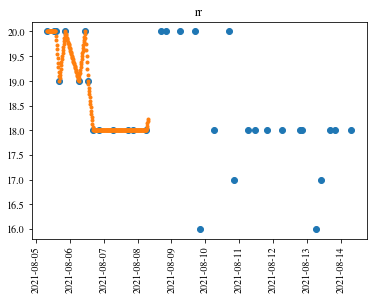

In [12]:

adm_no = 86452472
field = 'rr'
adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
adm_old = df_eobs_old[df_eobs_old['admission_id'] == adm_no]

plt.plot(adm_old['timestamp'],adm_old[field], 'o')
plt.plot(adm_new['timestamp'],adm_new[field], '.')
plt.title(field)
plt.xticks(rotation = 90)
plt.show()

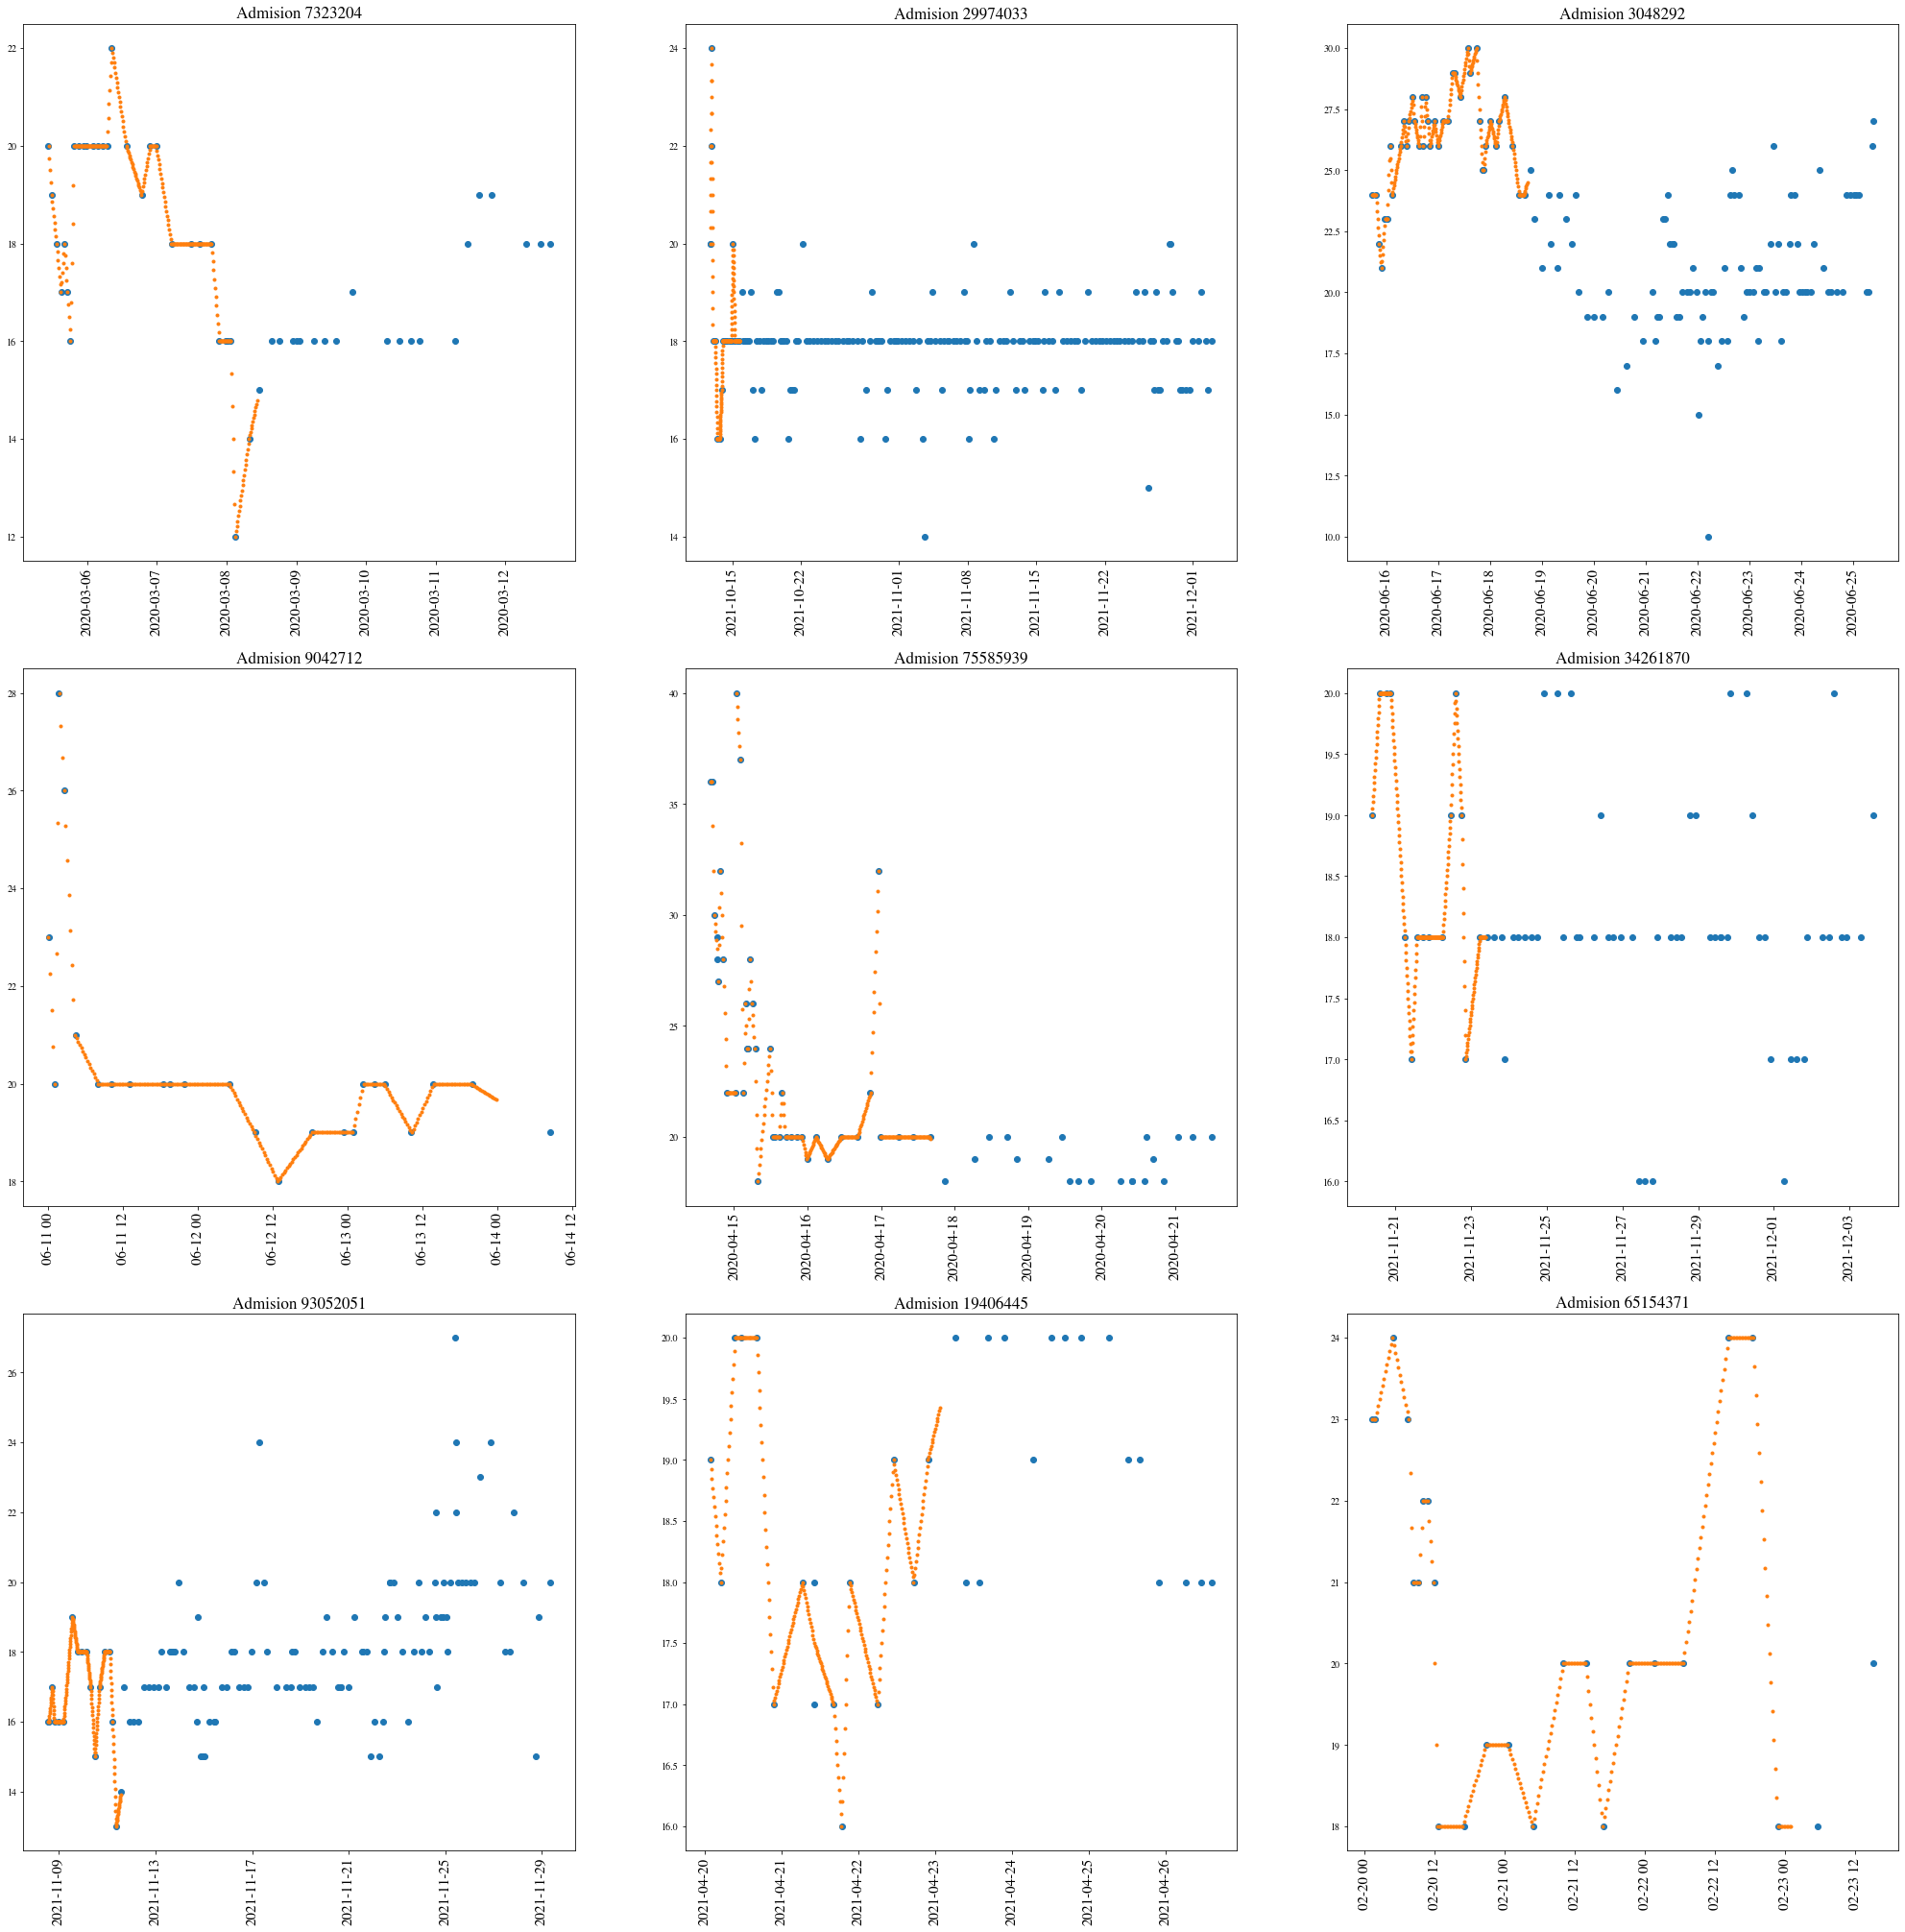

In [13]:
fig = plt.figure(figsize = (35,35))
n_plots = 9
admns = df_eobs_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)


for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    
    adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
    adm_old = df_eobs_old[df_eobs_old['admission_id'] == adm_no]
    
    ax = fig.add_subplot(3, 3, i+1)
    
    ax.plot(adm_old['timestamp'],adm_old[field], 'o')
    ax.plot(adm_new['timestamp'],adm_new[field], '.')
    ax.set_title('Admision ' + str(adm_no), fontsize = 17)
    ax.tick_params(axis = 'x',rotation = 90, labelsize = 15)
    plt.savefig(r'Images/Valid_InterpolationTotalResults_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [14]:
dict_labels.keys()

dict_keys(['rr', 'heart_rate', 'temperature\r', 'sbp', 'dbp', 'Oxygen_Saturation'])

In [15]:
def plot_eobs_admin(adm_no, save = False):
    adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
    adm_old = df_eobs_old[(df_eobs_old['admission_id'] == adm_no) &
                         (df_eobs_old['timestamp'] <= adm_new['timestamp'].max())]

    adm_sat = df_oxyge[(df_oxyge['admission_id'] == adm_no) &
             (df_oxyge['timestamp'] <= adm_new['timestamp'].max())]
    fig = plt.figure(figsize = (35,8))
    for i,field in enumerate(dict_labels.keys()):

        ax = fig.add_subplot(1,6 , i+1)

        ax.plot(adm_new['timestamp'],adm_new[field], '.-', label = 'Interpolation')
        if field == 'Oxygen_Saturation': 
            ax.plot(adm_sat['timestamp'],adm_sat[field], 'o', label = 'Original', markersize =10)
        else:
            ax.plot(adm_old['timestamp'],adm_old[field], 'o', label = 'Original', markersize =10)

        #ax.set_title(field, fontsize = 17)
        fig.text(0.09, 0.5, 'admission ' + str(adm_no), va='center', rotation='vertical', fontsize = 30)
        ax.tick_params(axis = 'x',rotation = 90, labelsize = 20)
        ax.tick_params(axis = 'y', labelsize = 20)

    fig.text(0.145, 0.95, 'Respiratory rate', va='center', fontsize = 30)
    fig.text(0.29, 0.95, 'Heart rate', va='center', fontsize = 30)
    fig.text(0.415, 0.95, 'Temperature', va='center', fontsize = 30)
    fig.text(0.55, 0.95, 'Systolic bp', va='center', fontsize = 30)
    fig.text(0.68, 0.95, 'Diastolic bp', va='center', fontsize = 30)
    fig.text(0.80, 0.95, 'Oxygen Saturation', va='center', fontsize = 30)
    if save == True:
        plt.savefig(r'Images/Valid_InterpolationEObsExample_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
    plt.show()

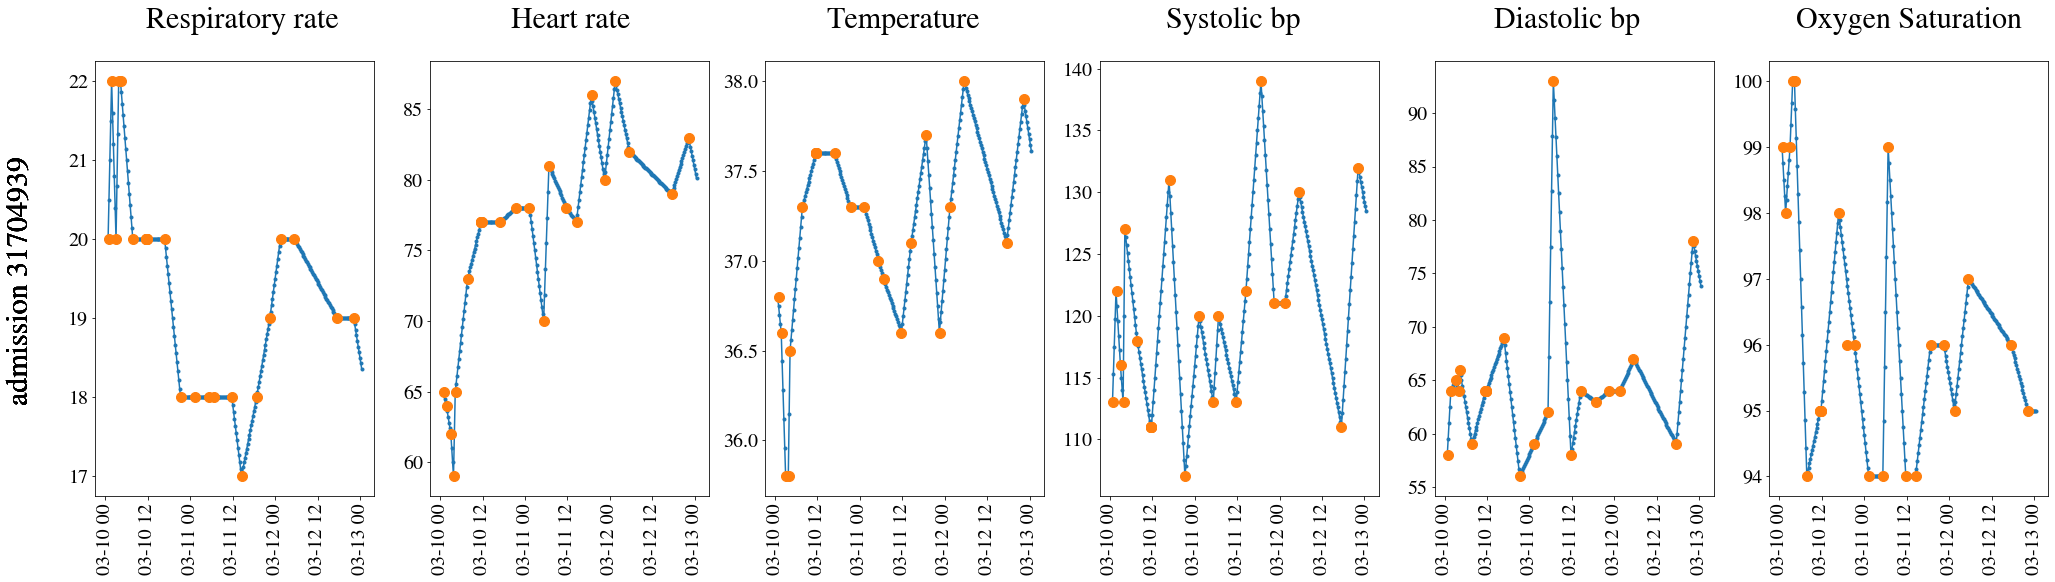

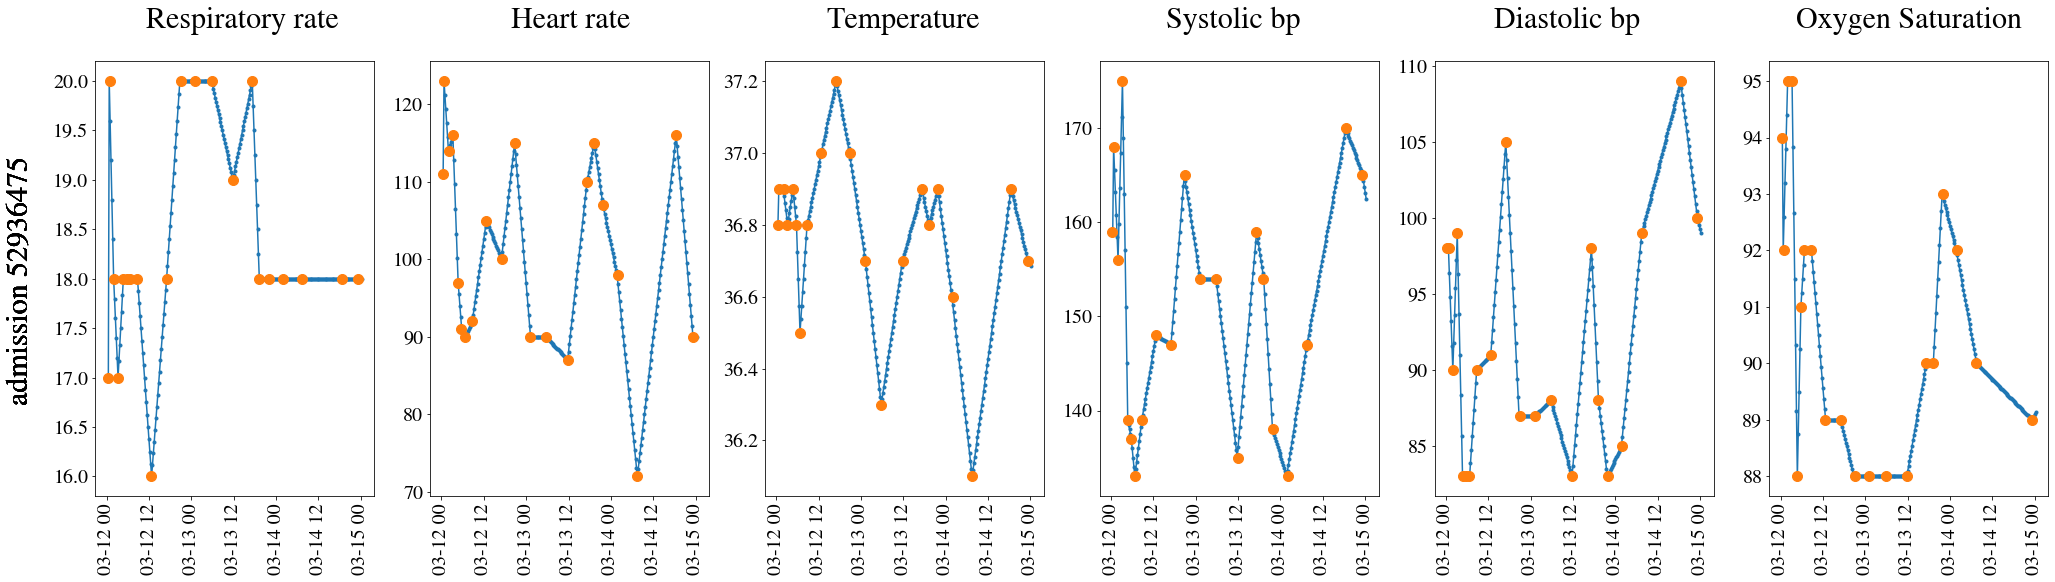

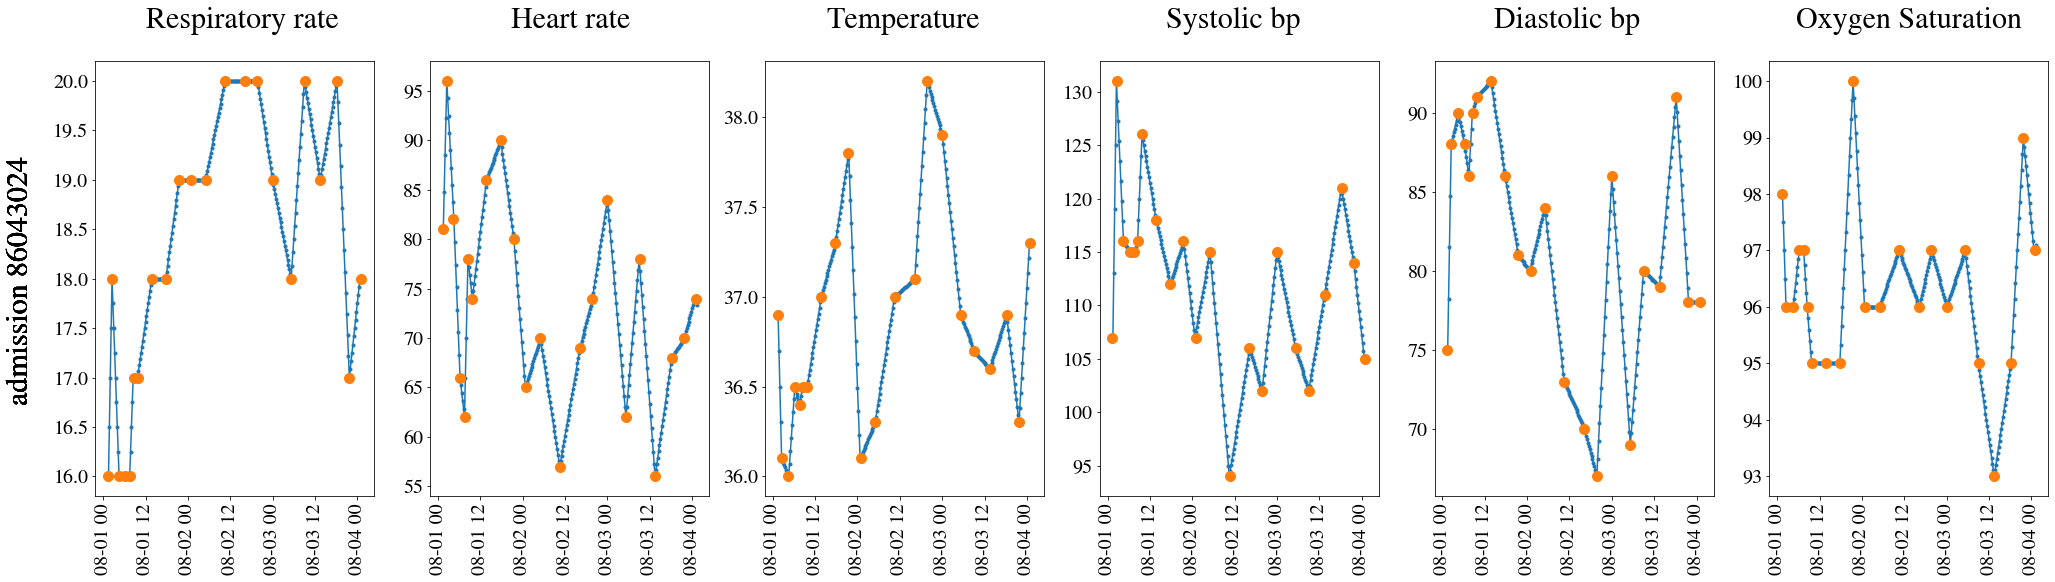

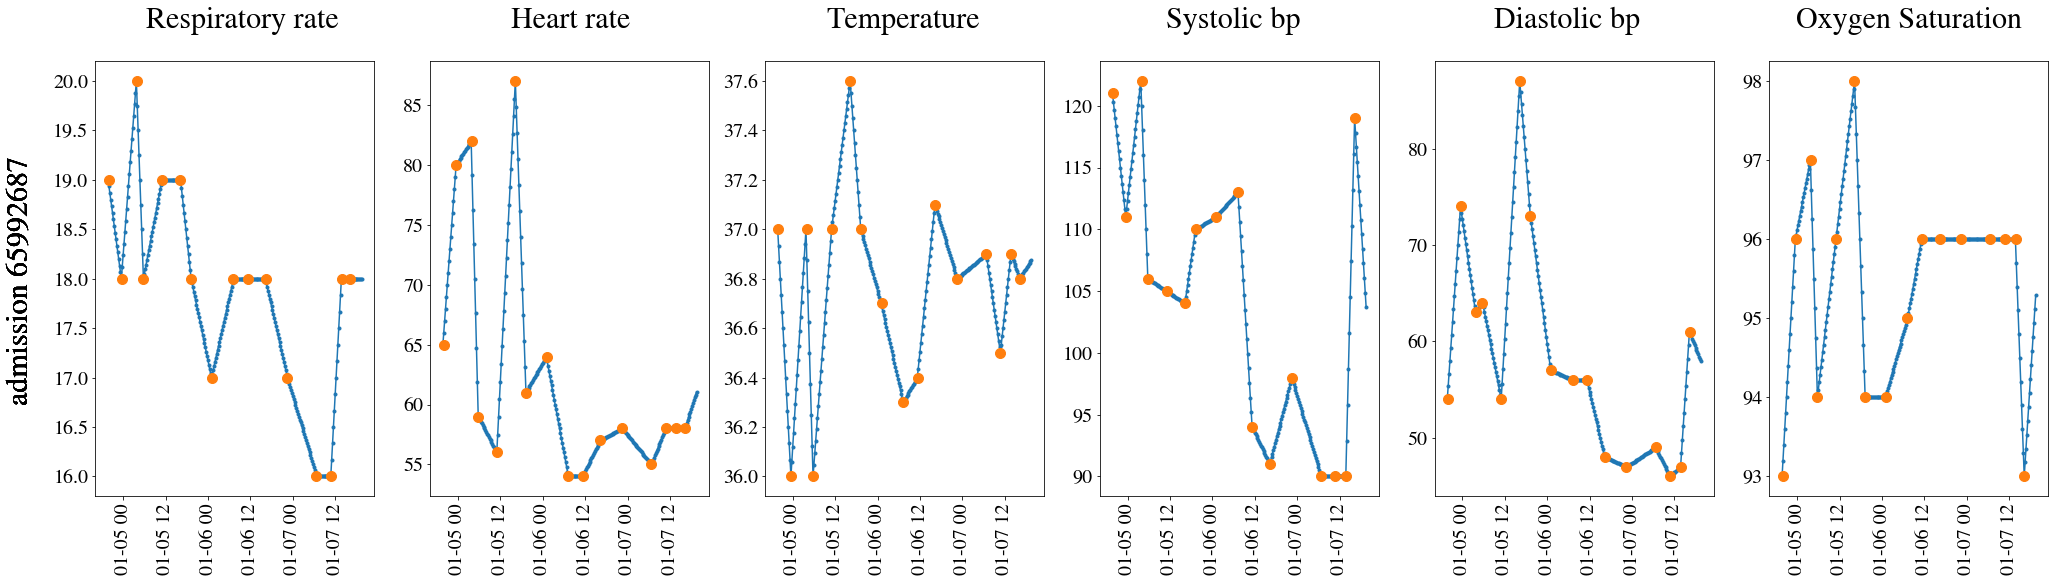

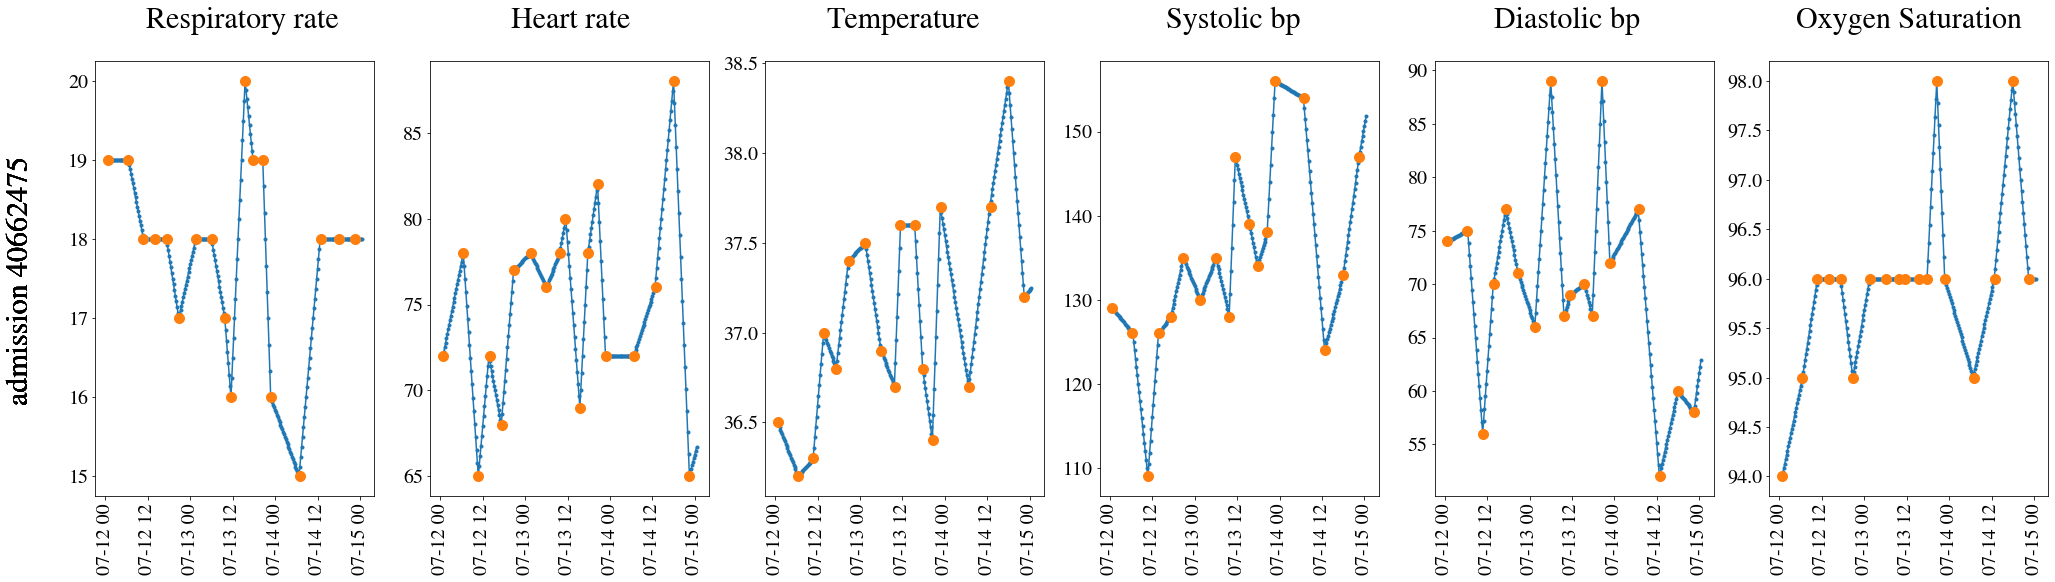

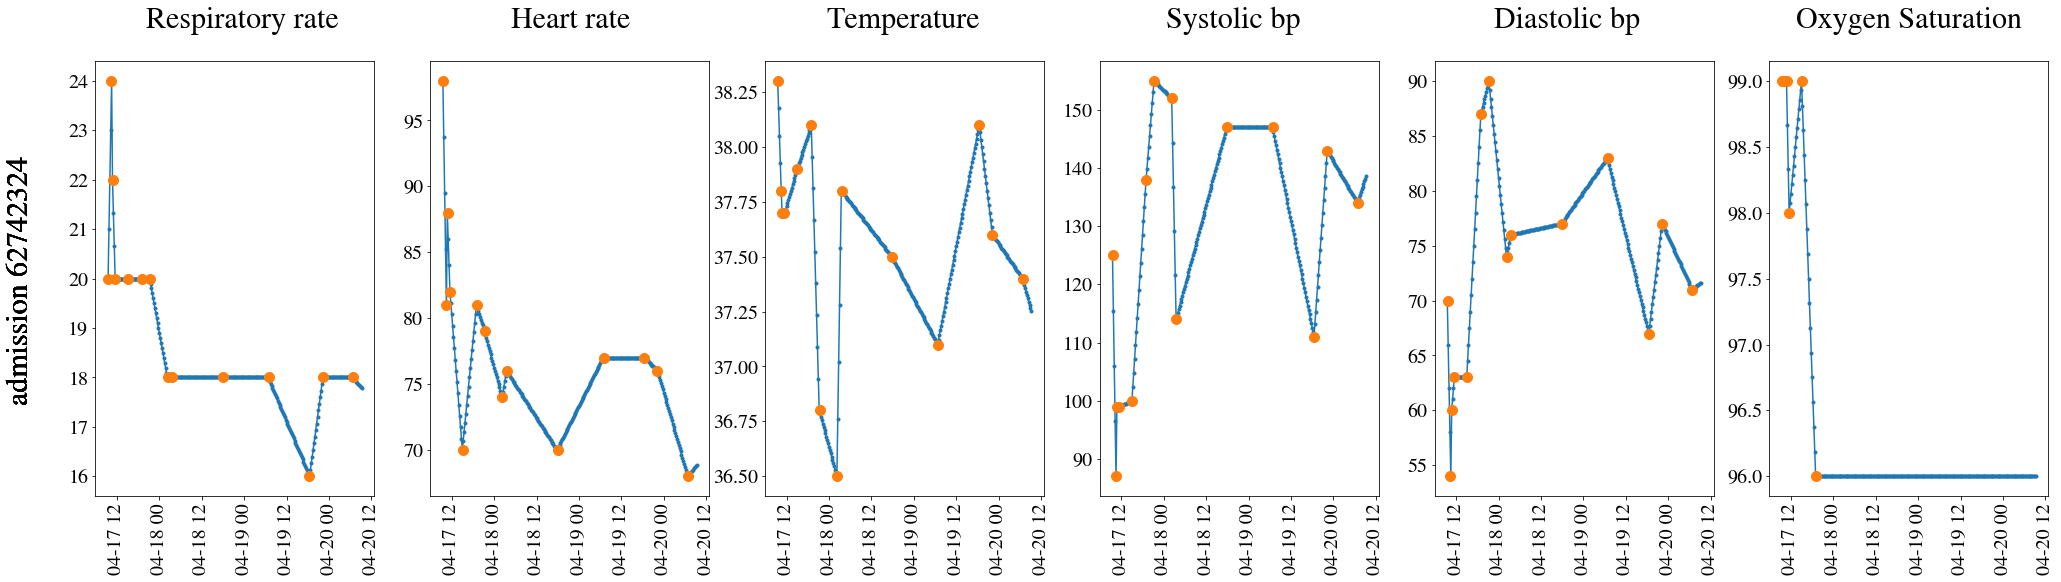

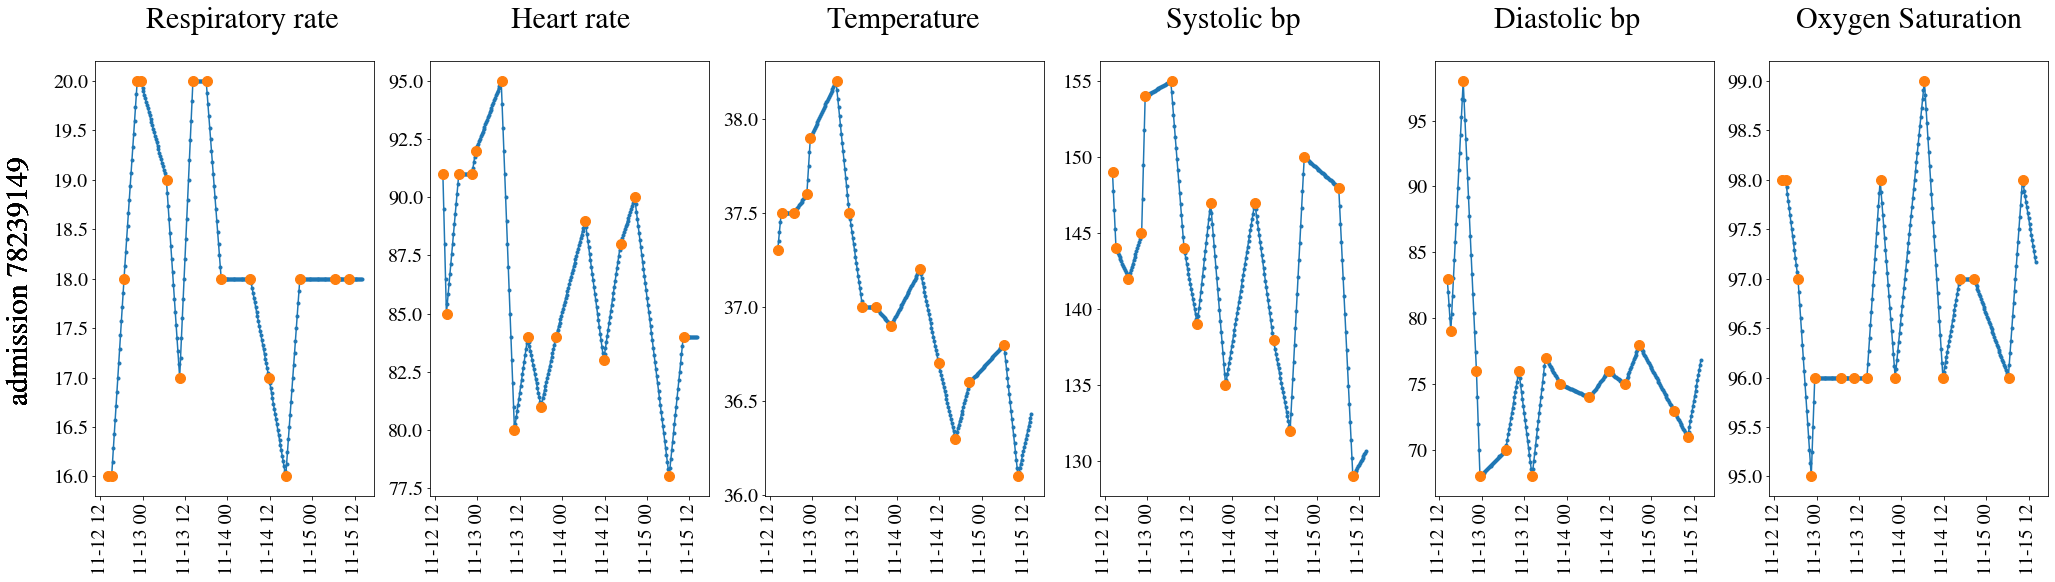

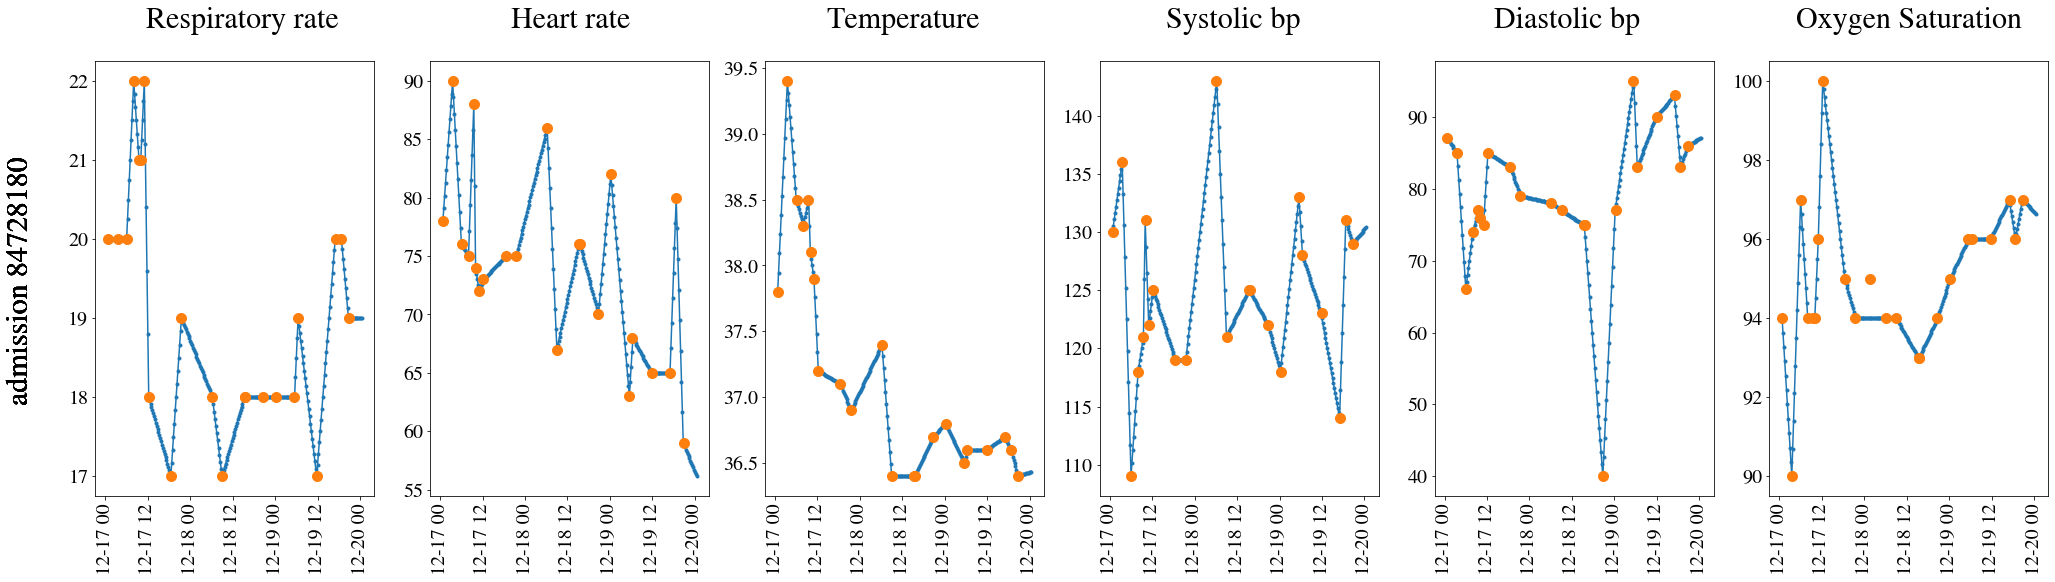

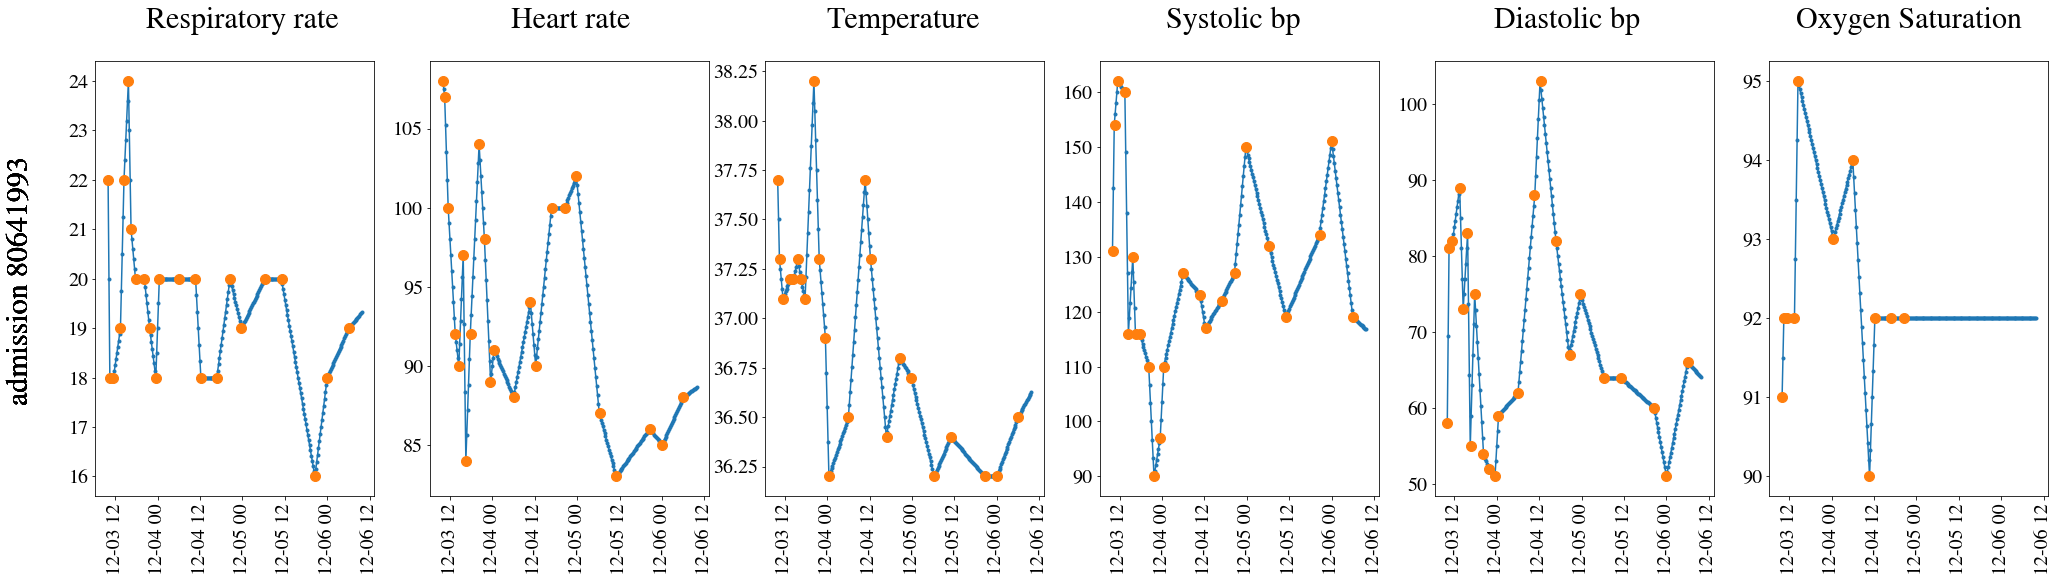

In [16]:

n_plots = 9
admns = df_eobs_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)

for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    plot_eobs_admin(adm_no, save = True)
    